In [51]:
import numpy as np

In [52]:
def tile_coding(state, num_tilings, tiles_per_dim, state_space_bounds, offset=0.1):
    encoded_state = np.zeros((num_tilings, *([tiles_per_dim] * len(state_space_bounds))))
    
    for tiling in range(num_tilings):
        tile_indices = []
        
        for i, (s, bounds) in enumerate(zip(state, state_space_bounds)):
            scale = tiles_per_dim / (bounds[1] - bounds[0] + offset * (num_tilings - 1))
            tiling_offset = tiling * offset / tiles_per_dim
            
            tile_index = np.floor(scale * (s - bounds[0] + tiling_offset)).astype(int) % tiles_per_dim
            tile_indices.append(tile_index)
        
        encoded_state[(tiling, *tile_indices)] = 1
    
    return encoded_state.flatten()

cp_num_tilings = 4
cp_tiles_per_dim = 5
cp_bounds=[(-2.4, 2.4), (-np.inf, np.inf), (-0.5, 0.5), (-np.inf, np.inf)]
cp_practical_bounds = [(-2.4, 2.4), (-5.0, 5.0), (-0.418, 0.418), (-5.0, 5.0)]
cp_num_actions = 2

def clip_state(state, bounds) :
    clipped_state = np. clip(state, [b[0] for b in bounds], [b[1] for b in bounds])
    return clipped_state




In [53]:
class ReinforceAgent:
    def agent_init(self, agent_info = {}, adam_info = {}):
        self.iht_size = agent_info.get('iht_size')
        self.num_tilings = agent_info.get('num_tilings')
        self.num_tiles = agent_info.get('num_tiles')
        self.step_size = agent_info.get('step_size')
        self.discount_factor = agent_info.get('discount_factor')
        self.num_actions = agent_info.get('num_actions')
        self.T = agent_info.get('temperature')
        self.bounds = [(-2.4, 2.4), (-5.0, 5.0), (-0.418, 0.418), (-5.0, 5.0)]
        self.theta = np.random.uniform(low=-0.001, high=0.001, size=(self.num_actions * self.iht_size, ))

    def transform_observation_wrapper(self, state):
        encoded_state = tile_coding(state, self.num_tilings, self.num_tiles, self.bounds).flatten()
        return encoded_state
    
    def agent_step(self, state):
        action = self.policy(state)
        return action

    def agent_end(reward):
        pass

    def get_state_action_feature(self, state, action):
        """
        Take state and action as input, encode it through tile coding and stack it to produce feature
        """
        active_tile = state
        active_feature_per_action = np.zeros((self.iht_size, ))
        active_feature_per_action[active_tile.astype(int)] = 1
        active_state_action_feature = np.zeros((self.num_actions * self.iht_size, ))
        active_state_action_feature[self.iht_size * action:self.iht_size * (action+1)] = active_feature_per_action
        return active_state_action_feature

    def get_action_value(self, active_state_action_feature):
        action_value = np.dot(self.theta, active_state_action_feature)
        return action_value

    def softmax(self, state):
        preferences = []
        for a in range(self.num_actions):
            active_state_action_feature = self.get_state_action_feature(state, a)
            action_value = self.get_action_value(active_state_action_feature)
            preferences.append(action_value)
        preferences = np.array(preferences)
        max_preferences = np.max(preferences)
        preferences = (preferences - max_preferences)/self.T
        exp_preferences = np.exp(preferences)
        sum_exp_preferences  = np.sum(exp_preferences)
        action_probs = exp_preferences / sum_exp_preferences
        return action_probs

    def policy(self, state):
        action_probs = self.softmax(state)
        #print(action_probs)
        action = np.random.choice(self.num_actions, p=action_probs)
        return action

    def get_gradient(self, state, action):
        active_state_action_feature = self.get_state_action_feature(state, action)
        action_probs = self.softmax(state)

        feature_set = []
        for a in range(self.num_actions):
            feature = self.get_state_action_feature(state, a)
            feature_set.append(feature)
        feature_set = np.array(feature_set)
        expected_feature_value = np.dot(action_probs, feature_set)


        gradient = active_state_action_feature - expected_feature_value
        return gradient

    def update_weight(self, action, state, g, t):
        gradient = self.get_gradient(state, action)
        self.theta = self.theta + self.step_size * (self.discount_factor ** t) * g * gradient


Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50


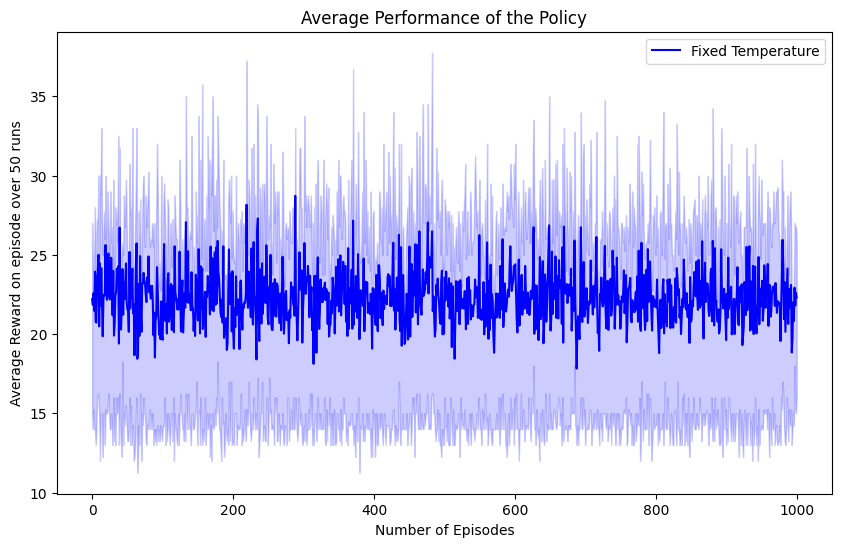

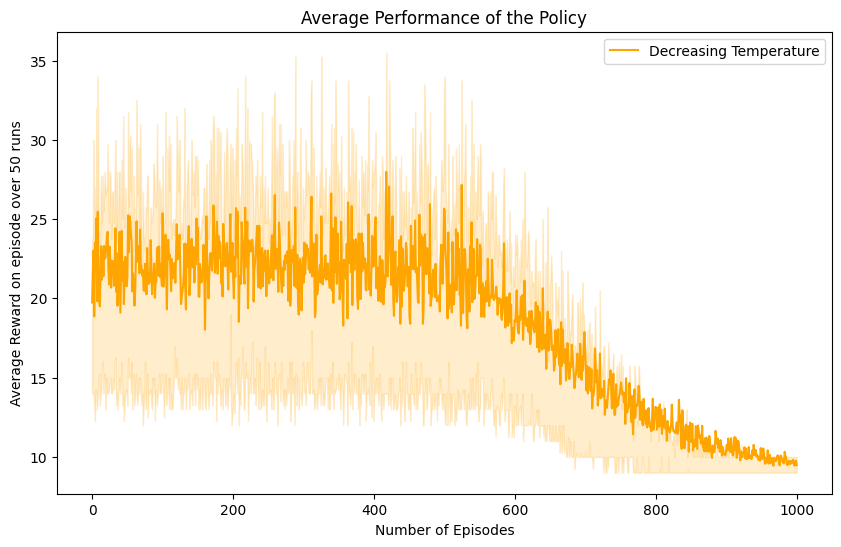

In [55]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import TransformObservation, TimeLimit
import matplotlib.pyplot as plt
from pathos.multiprocessing import ProcessingPool as Pool
# models = [REINFORCE, ActorCritic]



# Initialize environment
env=gym.make('CartPole-v1')



# Define parameters
num_episode = 1000  # Number of episodes per trial
num_trials =  50   # Number of trials
fixed_temperature = 1  # Fixed temperature for the first configuration
initial_temperature = 1  # Initial temperature for the second configuration

# Initialize results arrays
results_fixed_temp = np.zeros((num_trials, num_episode))
results_dec_temp = np.zeros((num_trials, num_episode))

 # Initialize REINFORCE agent with fixed temperature
agent_fixed_temp = ReinforceAgent()
agent_fixed_temp.agent_init({
    'num_actions': env.action_space.n, 'iht_size': 256,
    'num_tilings': 2, 'num_tiles': 5,
    'step_size': 2e-13, 'discount_factor': 0.99,
    'temperature': fixed_temperature  # Fixed temperature
})


# Initialize REINFORCE agent with decreasing temperature
agent_dec_temp = ReinforceAgent()
agent_dec_temp.agent_init({
    'num_actions': env.action_space.n, 'iht_size': 128,
    'num_tilings': 4, 'num_tiles': 5,
    'step_size': 2e-13, 'discount_factor':0.99,
    'temperature': initial_temperature  # Decreasing temperature
})
env = TransformObservation(env, lambda state : agent_fixed_temp.transform_observation_wrapper(clip_state(state, cp_practical_bounds)))

for trial in range(num_trials):
    print(f'Trial: {trial + 1}')

    # Initialize REINFORCE agent with fixed temperature
    agent_fixed_temp = ReinforceAgent()
    agent_fixed_temp.agent_init({
        'num_actions': env.action_space.n, 'iht_size': 128,
        'num_tilings': 2, 'num_tiles': 10,
        'step_size': 2e-13, 'discount_factor': 0.99,
        'temperature': fixed_temperature  # Fixed temperature
    })


    # Initialize REINFORCE agent with decreasing temperature
    agent_dec_temp = ReinforceAgent()
    agent_dec_temp.agent_init({
        'num_actions': env.action_space.n, 'iht_size': 256,
        'num_tilings': 2, 'num_tiles': 10,
        'step_size': 2e-13, 'discount_factor':0.99,
        'temperature': initial_temperature  # Decreasing temperature
    })


    # Episodes rollout for fixed temperature
    for episode in range(num_episode):

        # Generate_episodes
        state_ls = []
        action_ls = []
        reward_ls = []

        
        total_reward = 0
        state, inf = env.reset()
        done = False
        while not done:
            action = agent_fixed_temp.agent_step(state)
            state_ls.append(state)
            action_ls.append(action)
            state, reward, terminal, truncated, info = env.step(action)
            total_reward += reward
            reward_ls.append(reward)
            done = terminal or truncated
        results_fixed_temp[trial, episode] = total_reward
        


        

        for t in range(len(reward_ls)):
            g = 0
            power_arr = np.arange(t+1, len(state_ls))
            agent_discount_factor_arr = np.array([agent_fixed_temp.discount_factor] * len(power_arr))
            reward_arr = np.array(reward_ls[t:len(state_ls)-1])
            g = np.power(agent_discount_factor_arr, power_arr)
            g = np.dot(g, reward_arr)

            state = state_ls[t]
            action = action_ls[t]
            agent_fixed_temp.update_weight(action, state, g, t)
        




   
   
   
   
   
   
   
   
   

   
    # Episodes rollout for decreasing temperature
    for episode in range(num_episode):
   
        agent_dec_temp.T = agent_dec_temp.T*0.99

        # Generate_episodes
        state_ls = []
        action_ls = []
        reward_ls = []

        
        total_reward = 0
        state, inf = env.reset()
        done = False
        while not done:
            action = agent_dec_temp.agent_step(state)
            state_ls.append(state)
            action_ls.append(action)
            # print(env.state(action))
            state, reward, terminal, truncated, info = env.step(action)
            total_reward += reward
            reward_ls.append(reward)
            done = terminal or truncated
        results_dec_temp[trial, episode] = total_reward
        


        

        for t in range(len(reward_ls)):
            g2 = 0
            power_arr2 = np.arange(t+1, len(state_ls))
            agent_discount_factor_arr2 = np.array([agent_dec_temp.discount_factor] * len(power_arr2))
            reward_arr2 = np.array(reward_ls[t:len(state_ls)-1])
            g2 = np.power(agent_discount_factor_arr2, power_arr2)
            g2 = np.dot(g2, reward_arr2)

            state = state_ls[t]
            action = action_ls[t]
            agent_dec_temp.update_weight(action, state, g2, t)
        

# Calculate mean and interquantile range
mean_fixed_temp = np.mean(results_fixed_temp, axis=0)
mean_dec_temp = np.mean(results_dec_temp, axis=0)
quantiles_fixed_temp = np.percentile(results_fixed_temp, [25, 75], axis=0)
quantiles_dec_temp = np.percentile(results_dec_temp, [25, 75], axis=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(num_episode), mean_fixed_temp, label='Fixed Temperature', color='blue')
plt.fill_between(range(num_episode), quantiles_fixed_temp[0], quantiles_fixed_temp[1], color='blue', alpha=0.2)
plt.xlabel('Number of Episodes')
plt.ylabel('Average Reward on episode over 50 runs')
plt.title('Average Performance of the Policy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(num_episode), mean_dec_temp, label='Decreasing Temperature', color='orange')
plt.fill_between(range(num_episode), quantiles_dec_temp[0], quantiles_dec_temp[1], color='orange', alpha=0.2)
plt.xlabel('Number of Episodes')
plt.ylabel('Average Reward on episode over 50 runs')
plt.title('Average Performance of the Policy')
plt.legend()
plt.show()

env.close()


For both Fixed and Decaying Temperature configurations, the following hyperparameters were used after running several experiments:
Number of tiles per dimension = 10, Number of tilings = 10, Learning rate = 2e-13, Discount Factor = 0.99
For both configurations, we can see that the REINFORCE agent is not really learning to perform significantly better overtime. However, we can see that the configuration with fixed temperature performs better than the decaying temperature as seen by the average reward over time. Furthermore, we believe that REINFORCE with Baseline would perform better than the current agent due to the reduced variance.

 agent_fixed_temp.agent_init({
        'num_actions': env.action_space.n, 'iht_size': 128,
        'num_tilings': 4, 'num_tiles': 5,
        'step_size': 2e-13, 'discount_factor': 0.99,
        'temperature': fixed_temperature  # Fixed temperature
    })